In [1]:
!pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB

In [39]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
from datasets import load_dataset

food = load_dataset("food101", split="train[:5000]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [3]:
food

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

In [4]:
food = food.train_test_split(test_size=0.2)

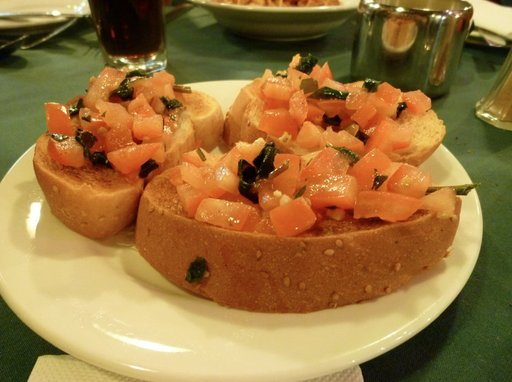

In [5]:
food["train"][0]['image']

In [6]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [7]:
id2label[str(79)]

'prime_rib'

In [8]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [9]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [10]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [11]:
food = food.with_transform(transforms)

In [12]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

size = (image_processor.size["height"], image_processor.size["width"])

train_data_augmentation = keras.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="train_data_augmentation",
)

val_data_augmentation = keras.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="val_data_augmentation",
)

In [14]:
import numpy as np
import tensorflow as tf
from PIL import Image


def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

In [15]:
food["train"].set_transform(preprocess_train)
food["test"].set_transform(preprocess_val)

In [16]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [17]:
import evaluate

accuracy = evaluate.load("accuracy")

In [18]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [19]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

In [21]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 1
num_train_steps = len(food["train"]) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [22]:
from transformers import TFAutoModelForImageClassification

model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
tf_train_dataset = food["train"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = food["test"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True,
    batch_size=batch_size, collate_fn=data_collator
)

In [24]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

In [25]:
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_eval_dataset)
#push_to_hub_callback = PushToHubCallback(
#    output_dir="food_classifier",
#    tokenizer=image_processor,
#    save_strategy="no",
#)
#callbacks = [metric_callback, push_to_hub_callback]
callbacks=metric_callback

In [26]:
model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=num_epochs, callbacks=callbacks)

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
250/250 [==============================] - 480s 2s/step - loss: 2.8400 - val_loss: 1.6597 - accuracy: 0.8270


In [27]:
ds = load_dataset("food101", split="validation[:10]")
image = ds["image"][0]

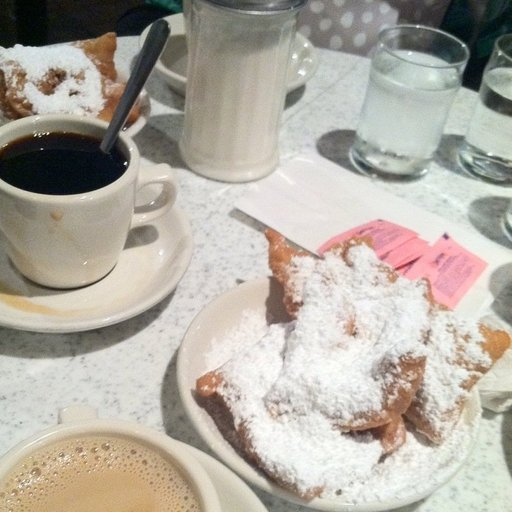

In [42]:
image

In [48]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("adam-bourne/food-classifier")
inputs = image_processor(image, return_tensors="tf")

In [49]:
logits = model(**inputs).logits

In [50]:
logits

<tf.Tensor: shape=(1, 101), dtype=float32, numpy=
array([[-0.48109928, -0.4961855 , -0.57646537, -0.52356666, -0.43691587,
        -0.40006372,  3.3010528 , -0.6684574 , -0.50821877, -0.24178119,
         0.5453576 , -0.3168394 , -0.49659613, -0.49208295, -0.575361  ,
        -0.45927507, -0.55808514, -0.6073486 , -0.54196966, -0.768406  ,
         0.544586  , -0.59191257, -0.6285311 , -0.67084986, -0.5411369 ,
        -0.46639758, -0.514248  , -0.7050967 , -0.5754583 , -0.53206694,
        -0.61601335, -0.5716087 , -0.5489414 , -0.43028617, -0.6249408 ,
        -0.48072878, -0.5344672 , -0.7663505 , -0.70840293, -0.78152174,
        -0.4800021 , -0.5469999 , -0.59565765, -0.3929565 , -0.7000599 ,
        -0.5008357 , -0.59876543, -0.6045333 , -0.47016457, -0.59901524,
        -0.4764569 , -0.4919372 , -0.5474166 ,  0.49984458, -0.6302732 ,
        -0.52472866, -0.54983574, -0.6980775 , -0.51418513, -0.58942497,
        -0.5887405 , -0.54704005, -0.5906247 , -0.47031343, -0.64138794,
 

In [54]:
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
id2label[str(6)]


'beignets'